In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import datasets, transforms
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import sys
import copy
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
import pandas as pd
import pickle



# 하이퍼파라미터 설정
batch_size = 64
epochs = 10
lr = 0.01
PCA_dim = 8
CLS_num = 2



with open('./data.pkl','rb') as file:
    data = pickle.load(file)
X = data['X']
y = data['Y']



x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)



def Fit_to_quantum(X,PCA_dim):
    pca = PCA(n_components=PCA_dim)
    X_pca = pca.fit_transform(X)
    return X_pca
    


# 정규화 (표준 스케일러 사용)
#x_train_pca = Fit_to_quantum(x_train,PCA_dim)
#x_test_pca = Fit_to_quantum(x_test,PCA_dim)

# PyTorch Tensor로 변환
x_train_pca, y_train = torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)
x_test_pca, y_test = torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)


class Feature_data_loader(Dataset):
    def __init__(self,x_train,y_train):
        self.feature1 = x_train
        temp = copy.deepcopy(x_train)
        shuffle = torch.randperm(len(temp))
        self.feature2 = temp[shuffle]
        
        self.y1 = y_train
        temp_y = copy.deepcopy(y_train)
        self.y2 = temp_y[shuffle]
        
    def __len__(self):
        return len(self.feature1)
    def __getitem__(self,idx):
        input1 = self.feature1[idx]
        input2 = self.feature2[idx]
        if self.y1[idx] == self.y2[idx]:
            label = torch.tensor(1.).float()
        else:
            label = torch.tensor(0.).float()
        return [input1,input2],label


# DataLoader 생성


train_loader = DataLoader(TensorDataset(x_train_pca, y_train.float()), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_pca, y_test.float()), batch_size=batch_size, shuffle=False)


In [2]:
def accuracy(pred, true):
    # 예측값이 로짓 혹은 확률값인 경우, 최대 값을 가진 인덱스를 구함 (가장 확률이 높은 클래스)
    pred = pred.detach().cpu()
    true = true.cpu()
    pred_labels = torch.round(pred)
    # 예측 레이블과 실제 레이블이 일치하는 경우를 계산
    correct = (pred_labels == true).sum()
    # 정확도를 계산
    acc = correct / true.size(0)
    return acc.item()

class Early_stop_train():
    def __init__(self,model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion



        self.loss_list = [1e100]
        self.stop_count = 0

    def train_model(self,train_loader,test_loader=None ,epochs=200,res = 10):
        self.model.train()
        for epoch in range(epochs):
            if self.stop_count>=res:
                break
            loss_val,_ = self.test(test_loader)
            self.loss_list.append(loss_val)

            if self.loss_list[-1]>=np.min(self.loss_list[:-1]):
                self.stop_count+=1
            else:
                self.stop_count = 0
            loss_list = []
            acc_list = []
            for X_train,y_train in train_loader:

                self.optimizer.zero_grad()
                output = self.model(X_train)

                loss = self.criterion(output.squeeze(), y_train)

                loss.backward()
                self.optimizer.step()
                loss_list.append(loss.item())
                acc = accuracy(output,y_train)
                acc_list.append(acc)

                sys.stdout.write(f"\rEpoch {epoch+1} Loss {np.mean(loss_list):4f} acc : {np.mean(acc_list):4f} stop count : {self.stop_count}")


    def test(self,test_loader):
        if test_loader is None:
            return 0,0
        else:
            #self.model.eval()
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data, target
                    output = self.model(data)
                    test_loss += self.criterion(output.squeeze(), target).item()

                    correct += accuracy(output,target)*len(output)

            print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')
            return test_loss,correct

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_breast_cancer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
import math
from kan import KAN





class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.cls_layer_1 = nn.Linear(PCA_dim,PCA_dim*PCA_dim)
        self.cls_layer_2 = nn.Linear(PCA_dim*PCA_dim,PCA_dim*2-1)
        self.output_layer = nn.Linear(2*PCA_dim-1,1)
    def forward(self, x):
        x = self.cls_layer_1(x)
        x = nn.ReLU()(x)
        x = self.cls_layer_2(x)
        x = nn.ReLU()(x)
        output = self.output_layer(x)
        output = nn.Sigmoid()(output)
        output = torch.squeeze(output)
        return output
# 모델, 손실 함수, 최적화 설정



model = Model(); criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)




train_process = Early_stop_train(model, optimizer, criterion)
train_process.train_model(train_loader,test_loader,epochs=5000,res=15)

_,acc = train_process.test(test_loader)
print(f"Test Accuracy: {acc:.2f}")




Test set: Average loss: 3.3810, Accuracy: 192.99999928474426/300 (64%)
Epoch 1 Loss 0.679389 acc : 0.637121 stop count : 0
Test set: Average loss: 3.3603, Accuracy: 208.00000095367432/300 (69%)
Epoch 2 Loss 0.675508 acc : 0.697538 stop count : 0
Test set: Average loss: 3.3397, Accuracy: 223.0/300 (74%)
Epoch 3 Loss 0.671888 acc : 0.738636 stop count : 0
Test set: Average loss: 3.3194, Accuracy: 231.99999976158142/300 (77%)
Epoch 4 Loss 0.668139 acc : 0.757860 stop count : 0
Test set: Average loss: 3.2993, Accuracy: 235.99999976158142/300 (79%)
Epoch 5 Loss 0.664487 acc : 0.771780 stop count : 0
Test set: Average loss: 3.2797, Accuracy: 235.00000071525574/300 (78%)
Epoch 6 Loss 0.660906 acc : 0.772348 stop count : 0
Test set: Average loss: 3.2600, Accuracy: 234.00000071525574/300 (78%)
Epoch 7 Loss 0.657210 acc : 0.778693 stop count : 0
Test set: Average loss: 3.2406, Accuracy: 237.00000071525574/300 (79%)
Epoch 8 Loss 0.653586 acc : 0.784470 stop count : 0
Test set: Average loss: 3.22

In [4]:
from kan import KAN, create_dataset
def reg(acts_scale,KAN_layer, factor=1,lamb_l1=1.,lamb_entropy=2.,lamb_coef=0.,lamb_coefdiff=0.):

    def nonlinear(x, th=1e-16):
        return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

    reg_ = 0.
    for i in range(len(acts_scale)):
        vec = acts_scale[i].reshape(-1, )

        p = vec / torch.sum(vec)
        l1 = torch.sum(nonlinear(vec))
        entropy = - torch.sum(p * torch.log2(p + 1e-4))
        reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

    # regularize coefficient to encourage spline to be zero
    for i in range(len(KAN_layer.act_fun)):
        coeff_l1 = torch.sum(torch.mean(torch.abs(KAN_layer.act_fun[i].coef), dim=1))
        coeff_diff_l1 = torch.sum(torch.mean(torch.abs(torch.diff(KAN_layer.act_fun[i].coef)), dim=1))
        reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1

    return reg_
def accuracy(pred, true):
    # 예측값이 로짓 혹은 확률값인 경우, 최대 값을 가진 인덱스를 구함 (가장 확률이 높은 클래스)
    pred = pred.detach().cpu()
    true = true.cpu()
    try:
        pred_labels = torch.argmax(pred, dim=1)
    except:
        pred_labels = torch.round(pred)
    # 예측 레이블과 실제 레이블이 일치하는 경우를 계산
    correct = (pred_labels == true).sum()
    # 정확도를 계산
    acc = correct / true.size(0)
    return acc.item() 

class Early_stop_train():
    def __init__(self,model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        

        
        self.loss_list = [1e100]
        self.acc_list = []
        self.stop_count = 0
        
    def train_model(self,train_loader,test_loader=None ,epochs=200,res = 10,lamb=0.):
        #self.model.train()
        
        for epoch in range(epochs):
            if self.stop_count>=res:
                break
            loss_val,_ = self.test(test_loader)
            self.loss_list.append(loss_val)
            
            if self.loss_list[-1]>=np.min(self.loss_list[:-1]):
                self.stop_count+=1
            else:
                self.optimal = self.model.state_dict()
                self.stop_count = 0
            loss_list = []
            acc_list = []
            for X_train,y_train in train_loader:
                self.optimizer.zero_grad()
                output = self.model(X_train)
                reg_ = lamb*reg(self.model.KAN.acts_scale,self.model.KAN)
                try:
                    loss = self.criterion(output.squeeze(), y_train)+reg_
                except:
                    print(output)
                    raise
                loss.backward()
                self.optimizer.step()
                loss_list.append(loss.item())
                acc = accuracy(output,y_train)
                acc_list.append(acc)
                sys.stdout.write(f"\rEpoch {epoch+1} Loss {np.mean(loss_list):4f} acc : {np.mean(acc_list):4f} reg : {reg_:4f} stop count : {self.stop_count}")
        self.model.load_state_dict(self.optimal)
    def test(self,test_loader):
        if test_loader is None:
            return 0,0
        else:
            #self.model.eval()
            test_loss = 0
            correct = 0
            with torch.no_grad():
                for data, target in test_loader:
                    output = self.model(data)

                    test_loss += self.criterion(output.squeeze(), target).item()
                    
                    correct += accuracy(output,target)*len(output)

            print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)')
            return test_loss,correct

In [13]:
from kan import KAN
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.KAN = KAN([PCA_dim,PCA_dim*2-1,1])
    def forward(self, x):
        output = self.KAN(x)
        output = nn.Sigmoid()(output)
        output = torch.squeeze(output)
        return output


model = Model(); criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)




train_process = Early_stop_train(model, optimizer, criterion)
train_process.train_model(train_loader,test_loader,epochs=50,res=15,lamb=0.005)

_,acc = train_process.test(test_loader)
print(f"Test Accuracy: {acc:.2f}")


Test set: Average loss: 4.7787, Accuracy: 137.0/300 (46%)
Epoch 1 Loss 0.854547 acc : 0.564205 reg : 0.143961 stop count : 0
Test set: Average loss: 2.8329, Accuracy: 197.00000023841858/300 (66%)
Epoch 2 Loss 0.655222 acc : 0.803314 reg : 0.147836 stop count : 0
Test set: Average loss: 2.0591, Accuracy: 256.00000047683716/300 (85%)
Epoch 3 Loss 0.522999 acc : 0.855492 reg : 0.151723 stop count : 0
Test set: Average loss: 1.5426, Accuracy: 269.0000002384186/300 (90%)
Epoch 4 Loss 0.445240 acc : 0.898485 reg : 0.159091 stop count : 0
Test set: Average loss: 1.2626, Accuracy: 272.99999952316284/300 (91%)
Epoch 5 Loss 0.398724 acc : 0.908523 reg : 0.161038 stop count : 0
Test set: Average loss: 1.1947, Accuracy: 277.99999952316284/300 (93%)
Epoch 6 Loss 0.379580 acc : 0.928598 reg : 0.160288 stop count : 0
Test set: Average loss: 1.1574, Accuracy: 276.99999952316284/300 (92%)
Epoch 7 Loss 0.360878 acc : 0.921307 reg : 0.160668 stop count : 0
Test set: Average loss: 1.1207, Accuracy: 279.9

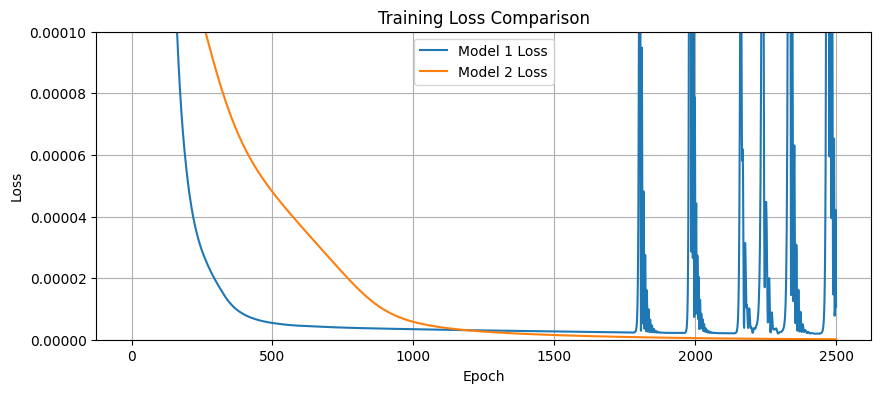

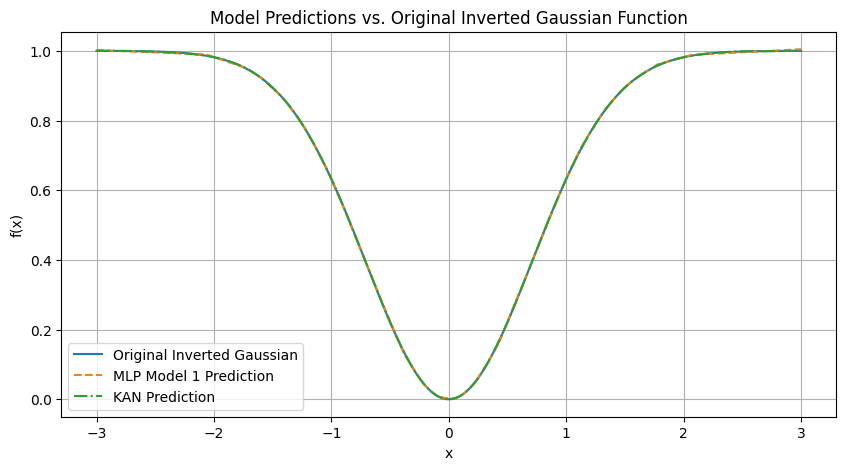

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from kan import KAN
# 데이터 생성
x = np.linspace(-3, 3, 400)
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y = 1 - np.exp(-x**2)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 두 가지 MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.layers(x)
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.KAN = KAN([1,5,2,1],grid=5)
    def forward(self, x):
        output = self.KAN(x)
        output = output
        return output

# 모델 초기화
model1 = MLP(1, 64, 1)
model2 = Model()  # 더 많은 뉴런을 가진 모델

# 손실 함수와 최적화 알고리즘
criterion = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)
optimizer2 = optim.Adam(model2.parameters(), lr=0.01)

# 훈련 루프
epochs = 2500
losses1 = []
losses2 = []
for epoch in range(epochs):
    # 모델 1 훈련
    y_pred1 = model1(x_tensor)
    loss1 = criterion(y_pred1, y_tensor)
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()
    losses1.append(loss1.item())
    
    # 모델 2 훈련
    y_pred2 = model2(x_tensor)
    loss2 = criterion(y_pred2, y_tensor)
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()
    losses2.append(loss2.item())

# 결과 시각화
with torch.no_grad():
    y_pred1 = model1(x_tensor)
    y_pred2 = model2(x_tensor)

# Loss 그래프
plt.figure(figsize=(10, 4))
plt.plot(losses1, label='Model 1 Loss')
plt.plot(losses2, label='Model 2 Loss')
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 0.0001)
plt.legend()
plt.grid(True)

# 함수 형태 비교 그래프
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='Original Inverted Gaussian')
plt.plot(x, y_pred1.numpy(), label='MLP Model 1 Prediction', linestyle='--')
plt.plot(x, y_pred2.numpy(), label='KAN Prediction', linestyle='-.')
plt.title('Model Predictions vs. Original Inverted Gaussian Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.grid(True)
plt.show()



In [39]:
x_val

tensor([[-0.0075],
        [-2.4436],
        [-1.2406],
        [-0.3534],
        [ 1.5714],
        [-0.3083],
        [ 1.1805],
        [-1.3910],
        [-0.4586],
        [ 2.3083],
        [ 2.6090],
        [-0.5940],
        [ 2.5489],
        [ 2.8346],
        [-1.4060],
        [ 0.1429],
        [-0.1128],
        [ 0.8496],
        [ 0.8045],
        [-2.1880],
        [-1.4812],
        [ 1.0602],
        [ 0.6241],
        [-2.2932],
        [-1.0451],
        [-0.1729],
        [-0.9098],
        [ 1.6767],
        [ 0.9248],
        [ 2.5038],
        [-0.2180],
        [ 0.7895],
        [-2.6992],
        [ 0.0677],
        [-0.7293],
        [ 0.9699],
        [ 2.7143],
        [ 1.9624],
        [-2.0376],
        [-2.3684],
        [ 1.8571],
        [-0.0827],
        [ 2.9549],
        [-2.3233],
        [-2.1729],
        [-1.9624],
        [-0.7143],
        [-1.9774],
        [ 2.7744],
        [ 0.6391],
        [ 2.2782],
        [ 0.9850],
        [-2.

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
# 데이터 생성
x = np.linspace(-3, 3, 400)
y = 1 - np.exp(-x**2)

# 데이터를 텐서로 변환
x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)

# 데이터를 훈련 세트와 검증 세트로 분할
indices = torch.tensor([i for i in range(len(x_tensor))])
train_indices = indices[:int(len(indices) * 0.8)]
val_indices = indices[int(len(indices) * 0.8):]

x_train, y_train = x_tensor[train_indices], y_tensor[train_indices]
x_val, y_val = x_tensor[val_indices], y_tensor[val_indices]

# 두 가지 MLP 모델 정의
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size)
        )
    
    def forward(self, x):
        return self.layers(x)
    
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.KAN = KAN([1,5,2,1],grid=7)
    def forward(self, x):
        output = self.KAN(x)
        output = output
        return output
# 모델 초기화
model1 = MLP(1, 64, 1)
model2 = Model()

# 손실 함수와 최적화 알고리즘
criterion = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)
optimizer2 = optim.Adam(model2.parameters(), lr=0.01)

# 훈련 루프
epochs = 3000
train_losses1 = []
val_losses1 = []
train_losses2 = []
val_losses2 = []
for epoch in tqdm(range(epochs)):
    # 모델 1 훈련
    model1.train()
    y_pred1 = model1(x_train)
    loss1 = criterion(y_pred1, y_train)
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()
    train_losses1.append(loss1.item())
    
    # 모델 1 검증
    model1.eval()
    with torch.no_grad():
        y_val_pred1 = model1(x_val)
        val_loss1 = criterion(y_val_pred1, y_val)
    val_losses1.append(val_loss1.item())

    # 모델 2 훈련
    model2
    y_pred2 = model2(x_train)
    loss2 = criterion(y_pred2, y_train)
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()
    train_losses2.append(loss2.item())
    
    # 모델 2 검증
    model2
    with torch.no_grad():
        y_val_pred2 = model2(x_val)
        val_loss2 = criterion(y_val_pred2, y_val)
    val_losses2.append(val_loss2.item())

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses1, label='Model 1 Train Loss')
plt.plot(val_losses1, label='Model 1 Validation Loss')
plt.title('Model 1 Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses2, label='Model 2 Train Loss')
plt.plot(val_losses2, label='Model 2 Validation Loss')
plt.title('Model 2 Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


  0%|          | 0/3000 [00:00<?, ?it/s]

 32%|███▏      | 952/3000 [01:24<03:02, 11.24it/s]


KeyboardInterrupt: 

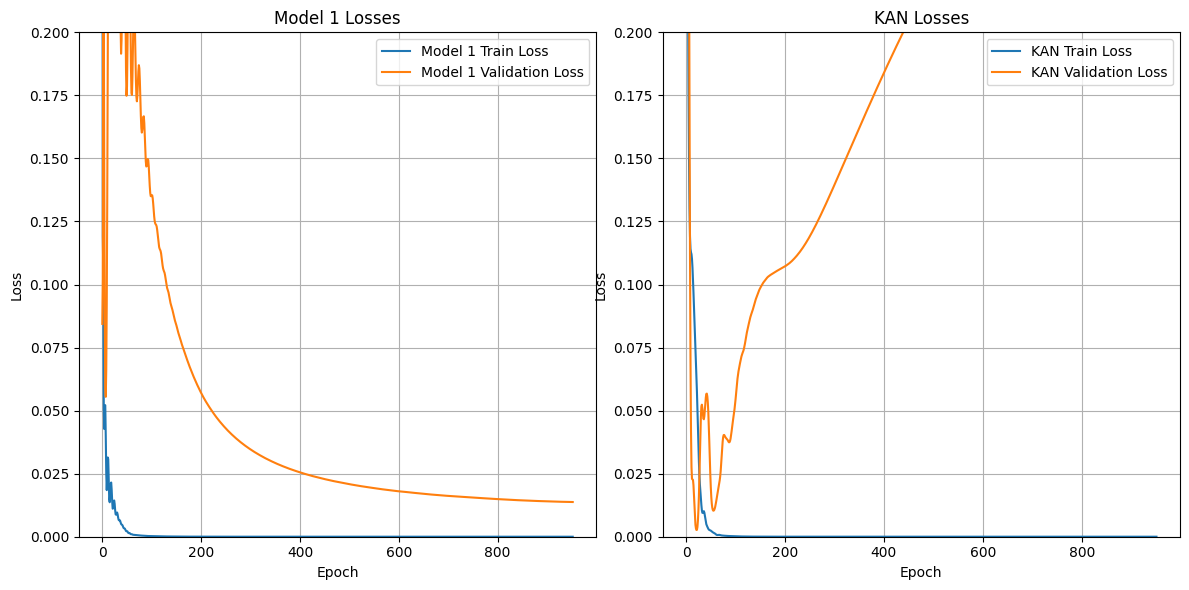

In [47]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses1, label='Model 1 Train Loss')
plt.plot(val_losses1, label='Model 1 Validation Loss')
plt.title('Model 1 Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, 0.2)


plt.subplot(1, 2, 2)
plt.plot(train_losses2, label='KAN Train Loss')
plt.plot(val_losses2, label='KAN Validation Loss')
plt.title('KAN Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 0.2)
plt.show()


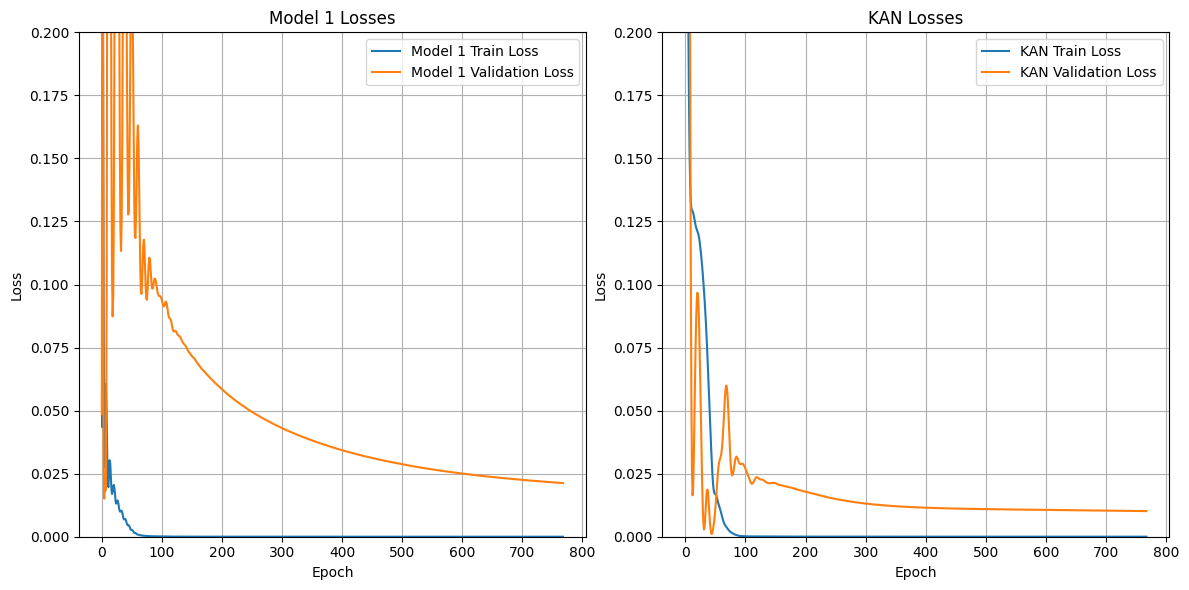

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses1, label='Model 1 Train Loss')
plt.plot(val_losses1, label='Model 1 Validation Loss')
plt.title('Model 1 Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.ylim(0, 0.2)


plt.subplot(1, 2, 2)
plt.plot(train_losses2, label='KAN Train Loss')
plt.plot(val_losses2, label='KAN Validation Loss')
plt.title('KAN Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.ylim(0, 0.2)
plt.show()


In [199]:
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 10),
            nn.GELU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.layers(x)

class ComplexMLP(nn.Module):
    def __init__(self):
        super(ComplexMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 64),
            nn.GELU(),
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, 64),
            nn.GELU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.layers(x)
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.KAN = KAN([1,2,1],grid=2)
    def forward(self, x):
        output = self.KAN(x)
        return output

In [200]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

# 데이터 생성
np.random.seed(0)
x = np.linspace(-3, 3, 300)
y = np.sin(x) + np.power(x, 2) + np.random.normal(0, 1, x.shape)  # 복잡한 함수에 노이즈 추가

# PyTorch 텐서로 변환
x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)

# 데이터셋 생성
dataset = TensorDataset(x_tensor, y_tensor)

# 훈련/검증 데이터로 분할
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 데이터 확인
print(f'Total dataset size: {len(dataset)}')
print(f'Training dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')


Total dataset size: 300
Training dataset size: 240
Validation dataset size: 60


In [201]:
# 모델 초기화
model1 = ComplexMLP()
model2 = Model()

# 손실 함수 및 최적화
criterion = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)
optimizer2 = optim.Adam(model2.parameters(), lr=0.01)


In [202]:
def reg(acts_scale,KAN_layer, factor=1,lamb_l1=1.,lamb_entropy=2.,lamb_coef=0.,lamb_coefdiff=0.):

    def nonlinear(x, th=1e-16):
        return (x < th) * x * factor + (x > th) * (x + (factor - 1) * th)

    reg_ = 0.
    for i in range(len(acts_scale)):
        vec = acts_scale[i].reshape(-1, )

        p = vec / torch.sum(vec)
        l1 = torch.sum(nonlinear(vec))
        entropy = - torch.sum(p * torch.log2(p + 1e-4))
        reg_ += lamb_l1 * l1 + lamb_entropy * entropy  # both l1 and entropy

    # regularize coefficient to encourage spline to be zero
    for i in range(len(KAN_layer.act_fun)):
        coeff_l1 = torch.sum(torch.mean(torch.abs(KAN_layer.act_fun[i].coef), dim=1))
        coeff_diff_l1 = torch.sum(torch.mean(torch.abs(torch.diff(KAN_layer.act_fun[i].coef)), dim=1))
        reg_ += lamb_coef * coeff_l1 + lamb_coefdiff * coeff_diff_l1
    return reg_


def train_and_validate(model, optimizer, num_epochs=500):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss / len(train_loader.dataset))

        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        val_losses.append(val_loss / len(val_loader.dataset))

        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / len(train_loader.dataset):.4f}, Val Loss: {val_loss / len(val_loader.dataset):.4f}')

    return train_losses, val_losses

def train_and_validate_KAN(model, optimizer, num_epochs=500,lamb = 0.1,lamb_enp = 2):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = 0
        for inputs, targets in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss = loss+lamb*reg(model.KAN.acts_scale,model.KAN,lamb_l1=lamb,lamb_entropy=lamb_enp)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        train_losses.append(train_loss / len(train_loader.dataset))

        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
        val_losses.append(val_loss / len(val_loader.dataset))

        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / len(train_loader.dataset):.4f}, Val Loss: {val_loss / len(val_loader.dataset):.4f}')

    return train_losses, val_losses


In [203]:
train_losses1, val_losses1 = train_and_validate(model1, optimizer1,num_epochs=200)
train_losses2, val_losses2 = train_and_validate_KAN(model2, optimizer2,lamb=0,num_epochs=200)


Epoch [50/200], Train Loss: 0.9793, Val Loss: 1.1915
Epoch [100/200], Train Loss: 0.9423, Val Loss: 1.4656
Epoch [150/200], Train Loss: 0.9609, Val Loss: 1.2114
Epoch [200/200], Train Loss: 0.9776, Val Loss: 1.3111
Epoch [50/200], Train Loss: 1.1353, Val Loss: 1.3207
Epoch [100/200], Train Loss: 0.9494, Val Loss: 1.1552
Epoch [150/200], Train Loss: 0.9146, Val Loss: 1.2069
Epoch [200/200], Train Loss: 0.8727, Val Loss: 1.1687


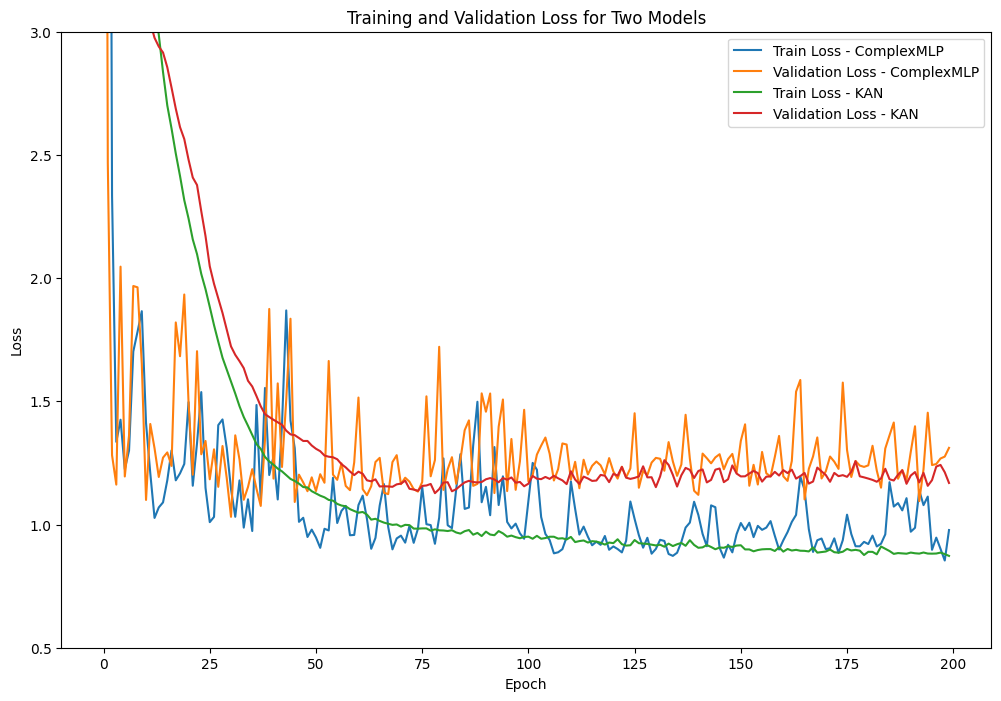

In [204]:
plt.figure(figsize=(12, 8))
plt.plot(train_losses1, label='Train Loss - ComplexMLP')
plt.plot(val_losses1, label='Validation Loss - ComplexMLP')
plt.plot(train_losses2, label='Train Loss - KAN')
plt.plot(val_losses2, label='Validation Loss - KAN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Two Models')
plt.legend()
plt.ylim(0.5,3)
plt.show()


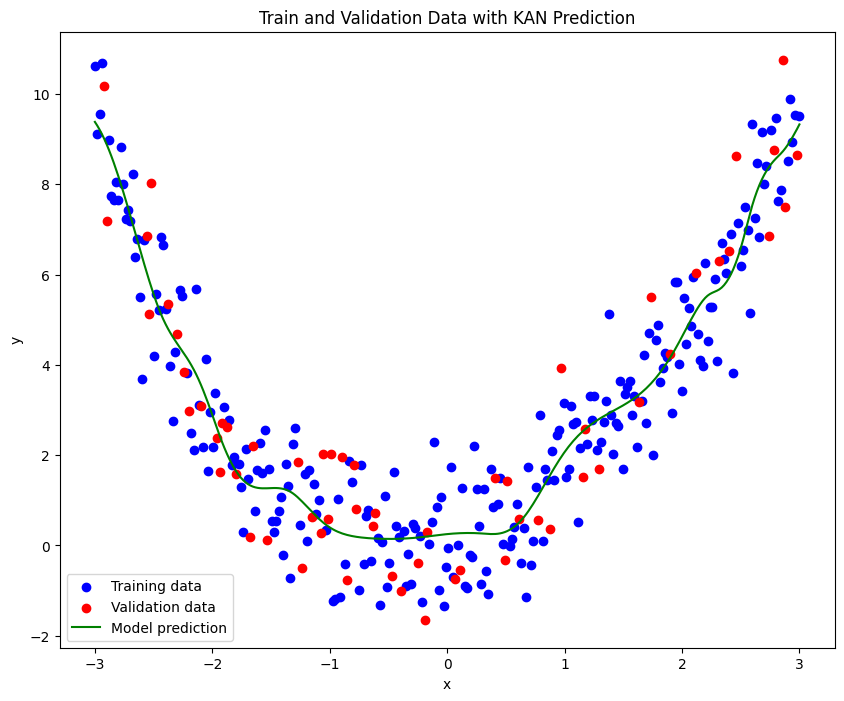

In [205]:
# 데이터와 모델의 예측 결과 시각화
plt.figure(figsize=(10, 8))
train_x, train_y = zip(*[(x.numpy(), y.numpy()) for x, y in train_dataset])
val_x, val_y = zip(*[(x.numpy(), y.numpy()) for x, y in val_dataset])

plt.scatter(train_x, train_y, color='blue', label='Training data')  # 훈련 데이터
plt.scatter(val_x, val_y, color='red', label='Validation data')  # 검증 데이터

with torch.no_grad():
    predictions = model2(x_tensor).numpy()  # 모델에 의한 예측

plt.plot(x, predictions, color='green', label='Model prediction')  # 예측 선
plt.xlabel('x')
plt.ylabel('y')
plt.title('Train and Validation Data with KAN Prediction')
plt.legend()
plt.show()


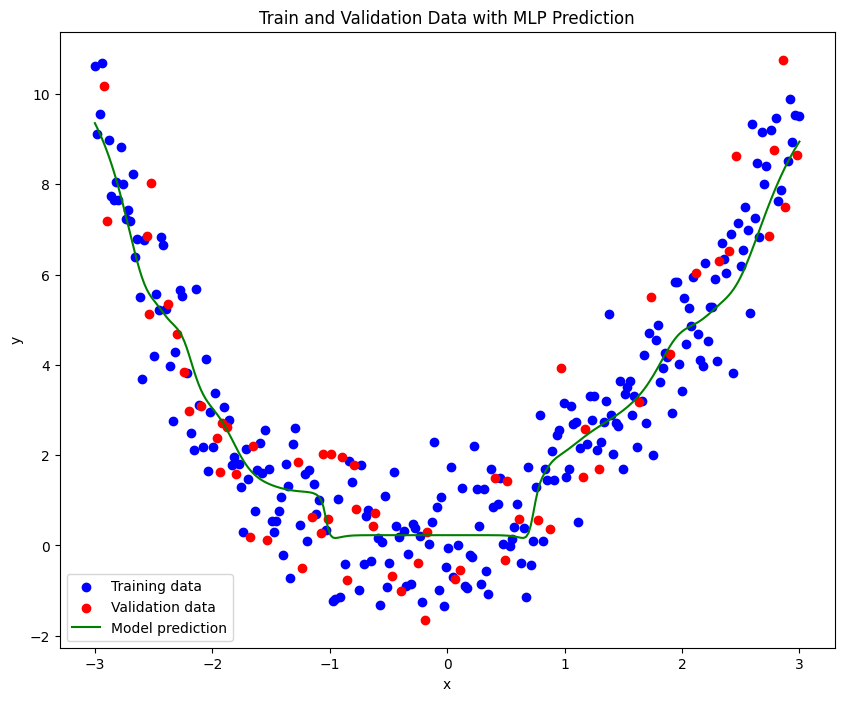

In [206]:
# 데이터와 모델의 예측 결과 시각화
plt.figure(figsize=(10, 8))
train_x, train_y = zip(*[(x.numpy(), y.numpy()) for x, y in train_dataset])
val_x, val_y = zip(*[(x.numpy(), y.numpy()) for x, y in val_dataset])

plt.scatter(train_x, train_y, color='blue', label='Training data')  # 훈련 데이터
plt.scatter(val_x, val_y, color='red', label='Validation data')  # 검증 데이터

with torch.no_grad():
    predictions = model1(x_tensor).numpy()  # 모델에 의한 예측

plt.plot(x, predictions, color='green', label='Model prediction')  # 예측 선
plt.xlabel('x')
plt.ylabel('y')
plt.title('Train and Validation Data with MLP Prediction')
plt.legend()
plt.show()